In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from bot import bot as class_bot 
from bot import get_table_decide_winner_classical
from typing import Literal



In [3]:
def get_antipos_classical_first(context,modulus):
    # возвращает первый выигрышный элемент
    ans=[]
    for i in context:
        ans.append((i+1)%modulus)
    return ans
     
def get_antipos_classical_random(context,modulus):
    #возвращает случайный выигрышный элемент
    ans=[]
    for i in context:
        ans.append(np.random.choice([(i+i) % modulus for i in range(1, (modulus-1)//2+1)]))

    return ans

def prepare_sequence(seq, to_ix):
        idxs = [to_ix[ch] for ch in seq]
        return torch.tensor(idxs, dtype=torch.long)

def get_initial(size,modulus,seed=42):
    np.random.seed(seed)
    s=[]
    for i in range(size):
        s.append(np.random.choice([i for i in range(modulus)]))
    return s



In [66]:
def create(embedding_dim,hidden_dim=64,architecture="lstm"):
    #architecture-lstm, rnn : to do- gru

   

    # Архитектура модели LSTM
    class TextGenerator(nn.Module):
        def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size,architecture):
            super(TextGenerator, self).__init__()
            self.hidden_dim = hidden_dim
    
            self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
            if architecture=="lstm":
                self.text = nn.LSTM(embedding_dim, hidden_dim)
            elif architecture=="rnn":
                self.text = nn.RNN(embedding_dim, hidden_dim)
            self.hidden = nn.Linear(hidden_dim, output_size)
            
        def forward(self, sentence):
            embeds = self.word_embeddings(sentence)
            text_out, _ = self.text(embeds.view(len(sentence), 1, -1))
            hidden = self.hidden(text_out.view(len(sentence), -1))
            
            return hidden
    
    # Подготовка данных и создание модели
    
    return TextGenerator(embedding_dim=embedding_dim, hidden_dim=hidden_dim,vocab_size=embedding_dim , output_size=embedding_dim, architecture=architecture)
    
    


def fit(model,number_of_states=7,epochs=16,batch_size=64,optimm="adam",loss="cross_entropy",
        bot_strategy="mrugesh",
        games_ahead=8,verbose=True):

    if loss=="cross_entropy":
        loss_function = nn.CrossEntropyLoss()
    if loss=="mse" or loss=="MSE":
        loss_function=nn.MSELoss()
    if optimm=="adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Обучение модели
    
    
    
    
    loss_history=[]
    
    model.train()
    for epoch in range(epochs):
        history=get_initial(games_ahead+1,modulus=number_of_states,seed=epoch)
        bot=class_bot(strategy=bot_strategy,number_of_states=number_of_states,initial_history=history.copy())
        for batch in range(batch_size):
            
           
            inputs = torch.tensor(history[-games_ahead-1:-1],dtype=torch.long )
            
            
            targets = torch.tensor(history[-games_ahead:], dtype=torch.long)  # Предсказание следующего символа

            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()



            #предсказали->перевернули-> записали ответ
            outputs_str=[]
            for i in range(games_ahead):
                output_dist = F.softmax(outputs[i], dim=0)
                top_i = torch.argmax(output_dist).item()
                outputs_str.append(top_i)


            ans=get_antipos_classical_first(outputs_str,modulus=number_of_states)
            history.extend(bot.play(ans))
        
            
            loss_history.append(loss.item())
            
            
        print(f'Epoch {epoch}, Loss: {loss.item()}')


    if verbose:
        plt.plot([i for i in range(epochs*batch_size)],loss_history)
        plt.show()
    
    return model,loss_history

In [59]:
def eval(model,bot_strategy, number_of_states=7,epochs=64,batch_size=64,
         enable_random=False,low_winrate=0.6, frequency=25,
         first_or_random:Literal["first","random"]="first"):
    # enable_random=True-при маленьком винрейте иногда начинает делать рандомные ходы
    # low_winrate - при каком винрейте начинать делам рандомные ходы , используется только при low_winrate==True
    # frequency- как часто при низком винрейте делать рандомные ходы , используется только при low_winrate==True
    model.eval()

    bot=class_bot(number_of_states=number_of_states,strategy=bot_strategy)
    
    decide_winner=get_table_decide_winner_classical(number_of_states)
    #history of bot moves
    history=get_initial(size=number_of_states,modulus=number_of_states)
    generated=history.copy()

    if first_or_random=="first":
        last_player_move=get_antipos_classical_first([generated[-1]],modulus=number_of_states)
    else:
        last_player_move=get_antipos_classical_random([generated[-1]],modulus=number_of_states)

    stats={"player_wins":0,"bot_wins":0,"tie":0}

    win_or_lose="1"*9

    winrate=1

    for epoch in range(1,epochs+1):
        history=get_initial(size=number_of_states,modulus=number_of_states)
        generated=history.copy()
    
        if first_or_random=="first":
            last_player_move=get_antipos_classical_first([generated[-1]],modulus=number_of_states)
        else:
            last_player_move=get_antipos_classical_random([generated[-1]],modulus=number_of_states)
        for batch in range(batch_size):

            input = torch.tensor(history,dtype=torch.long)
            output = model(input)
            output_dist = F.softmax(output[-1], dim=0)
            top_i = torch.argmax(output_dist).item()
            generated.append(top_i)
            #предсказали->перевернули->записали ответ
            if enable_random==True and winrate<low_winrate and epoch%frequency==0:
                    player_move=np.random.choice([i for i in range(number_of_states)])
            else:
                if first_or_random=="first":
                    player_move=get_antipos_classical_first([generated[-1]],modulus=number_of_states)
                else:
                    player_move=get_antipos_classical_random([generated[-1]],modulus=number_of_states)

            bot_move=bot.play(last_player_move)

            history.extend(bot_move)
            last_player_move=player_move
            
            if decide_winner[player_move[0]][bot_move[0]]=="w":
                stats["player_wins"]+=1
                win_or_lose=win_or_lose+"1"
            elif decide_winner[player_move[0]][bot_move[0]]=="t":
                stats["tie"]+=1
                win_or_lose=win_or_lose+"2"
            else:
                stats["bot_wins"]+=1
                win_or_lose=win_or_lose+"0"
            
        print(stats)
        winrate=stats['player_wins']/(epoch*batch_size)
        print(f"winrate=={winrate}")
            
    




    return generated,history,win_or_lose,stats


Epoch 0, Loss: 0.9119207859039307
Epoch 1, Loss: 0.3921079933643341
Epoch 2, Loss: 0.5269390940666199
Epoch 3, Loss: 0.4680061936378479
Epoch 4, Loss: 0.3894575834274292
Epoch 5, Loss: 0.3103141784667969
Epoch 6, Loss: 0.24446731805801392
Epoch 7, Loss: 0.26940402388572693
Epoch 8, Loss: 0.1153167188167572
Epoch 9, Loss: 0.23976173996925354
Epoch 10, Loss: 0.10806984454393387
Epoch 11, Loss: 0.10996869206428528
Epoch 12, Loss: 0.38525062799453735
Epoch 13, Loss: 0.43502840399742126
Epoch 14, Loss: 0.35495448112487793
Epoch 15, Loss: 0.3192324936389923


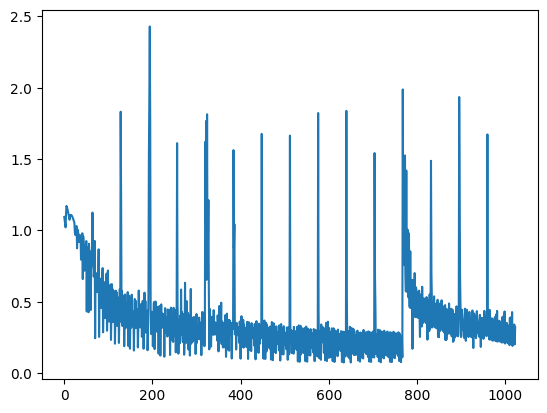

In [73]:
mrugesh=class_bot(strategy="mrugesh",number_of_states=3)

model=create(embedding_dim=3)

model,loss_history=fit(model,loss="cross_entropy",number_of_states=3,epochs=16,batch_size=64,games_ahead=16)



In [74]:
generated,actual_history,win_or_loses,stats=eval(model,number_of_states=3,bot_strategy="mrugesh")

{'player_wins': 11, 'bot_wins': 44, 'tie': 9}
winrate==0.171875
{'player_wins': 20, 'bot_wins': 86, 'tie': 22}
winrate==0.15625
{'player_wins': 29, 'bot_wins': 128, 'tie': 35}
winrate==0.15104166666666666
{'player_wins': 40, 'bot_wins': 174, 'tie': 42}
winrate==0.15625
{'player_wins': 51, 'bot_wins': 218, 'tie': 51}
winrate==0.159375
{'player_wins': 60, 'bot_wins': 260, 'tie': 64}
winrate==0.15625
{'player_wins': 69, 'bot_wins': 302, 'tie': 77}
winrate==0.15401785714285715
{'player_wins': 80, 'bot_wins': 348, 'tie': 84}
winrate==0.15625
{'player_wins': 91, 'bot_wins': 392, 'tie': 93}
winrate==0.1579861111111111
{'player_wins': 100, 'bot_wins': 434, 'tie': 106}
winrate==0.15625
{'player_wins': 109, 'bot_wins': 476, 'tie': 119}
winrate==0.15482954545454544
{'player_wins': 120, 'bot_wins': 522, 'tie': 126}
winrate==0.15625
{'player_wins': 131, 'bot_wins': 566, 'tie': 135}
winrate==0.15745192307692307
{'player_wins': 140, 'bot_wins': 608, 'tie': 148}
winrate==0.15625
{'player_wins': 149, '

In [ ]:
def get_initial(size,seed=None):
    if seed!=None:
        np.random.seed(seed)
    s=""
    for i in range(size):
        s+=np.random.choice(["R","P","S"])
    return s

get_initial(8)


'SRSSPRPP'